In [11]:
import pandas as pd
from datetime import time, timedelta
import matplotlib.pyplot as plt

# Read your data
df = pd.read_csv("./17.01 UPMC Demo/soln3Times.csv", index_col=0)

In [12]:
doctor_dfs = {}

# Function to convert minutes from start to actual time
def minutes_to_time(minutes):
    start_hour = 8  # 8 AM
    total_minutes = start_hour * 60 + minutes
    hours = (total_minutes // 60) % 24
    mins = total_minutes % 60
    return time(hours, mins)

# Split into 8 dataframes (one per doctor/machine)
for doctor_num in range(8):
    doctor_df = df[df['machine'] == doctor_num].copy()
    
    # Select and rename columns
    doctor_df = doctor_df[['job_id', 'start_time', 'end_time', 'processing_time', 'arrival_time']]
    doctor_df = doctor_df.rename(columns={'job_id': 'patient_id'})
    
    # Convert times to actual clock times
    doctor_df['start_time'] = doctor_df['start_time'].apply(minutes_to_time)
    doctor_df['end_time'] = doctor_df['end_time'].apply(minutes_to_time)
    doctor_df['arrival_time'] = doctor_df['arrival_time'].apply(minutes_to_time)
    
    # Sort by start time
    doctor_df = doctor_df.sort_values('start_time').reset_index(drop=True)
    
    # Store in dictionary with doctor number as key
    doctor_dfs[doctor_num] = doctor_df


In [13]:
# Access individual doctor schedules:
# doctor_dfs[0] for Doctor 0
# doctor_dfs[1] for Doctor 1, etc.
df = doctor_dfs[3]
df

,patient_id,start_time,end_time,processing_time,arrival_time
0,15,08:01:00,08:31:00,30,08:01:00
1,1,08:31:00,09:01:00,30,08:01:00
2,23,09:01:00,09:16:00,15,08:45:00
3,44,09:30:00,10:00:00,30,09:30:00
4,79,10:15:00,10:30:00,15,10:15:00
5,74,10:30:00,10:45:00,15,10:15:00
6,78,10:45:00,10:50:00,5,10:15:00
7,92,10:50:00,11:20:00,30,10:50:00
8,86,11:20:00,11:25:00,5,10:50:00
9,99,11:25:00,11:55:00,30,10:50:00


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

# Convert time strings to datetime for plotting
#df['start_time'] = pd.to_datetime(df['start_time'])
#df['end_time'] = pd.to_datetime(df['end_time'])

# Assign machines (example: round-robin by patient_id)
df['machine'] = 3

# Optional: Sort by start_time for cleaner visualization
df = df.sort_values('start_time').reset_index(drop=True)

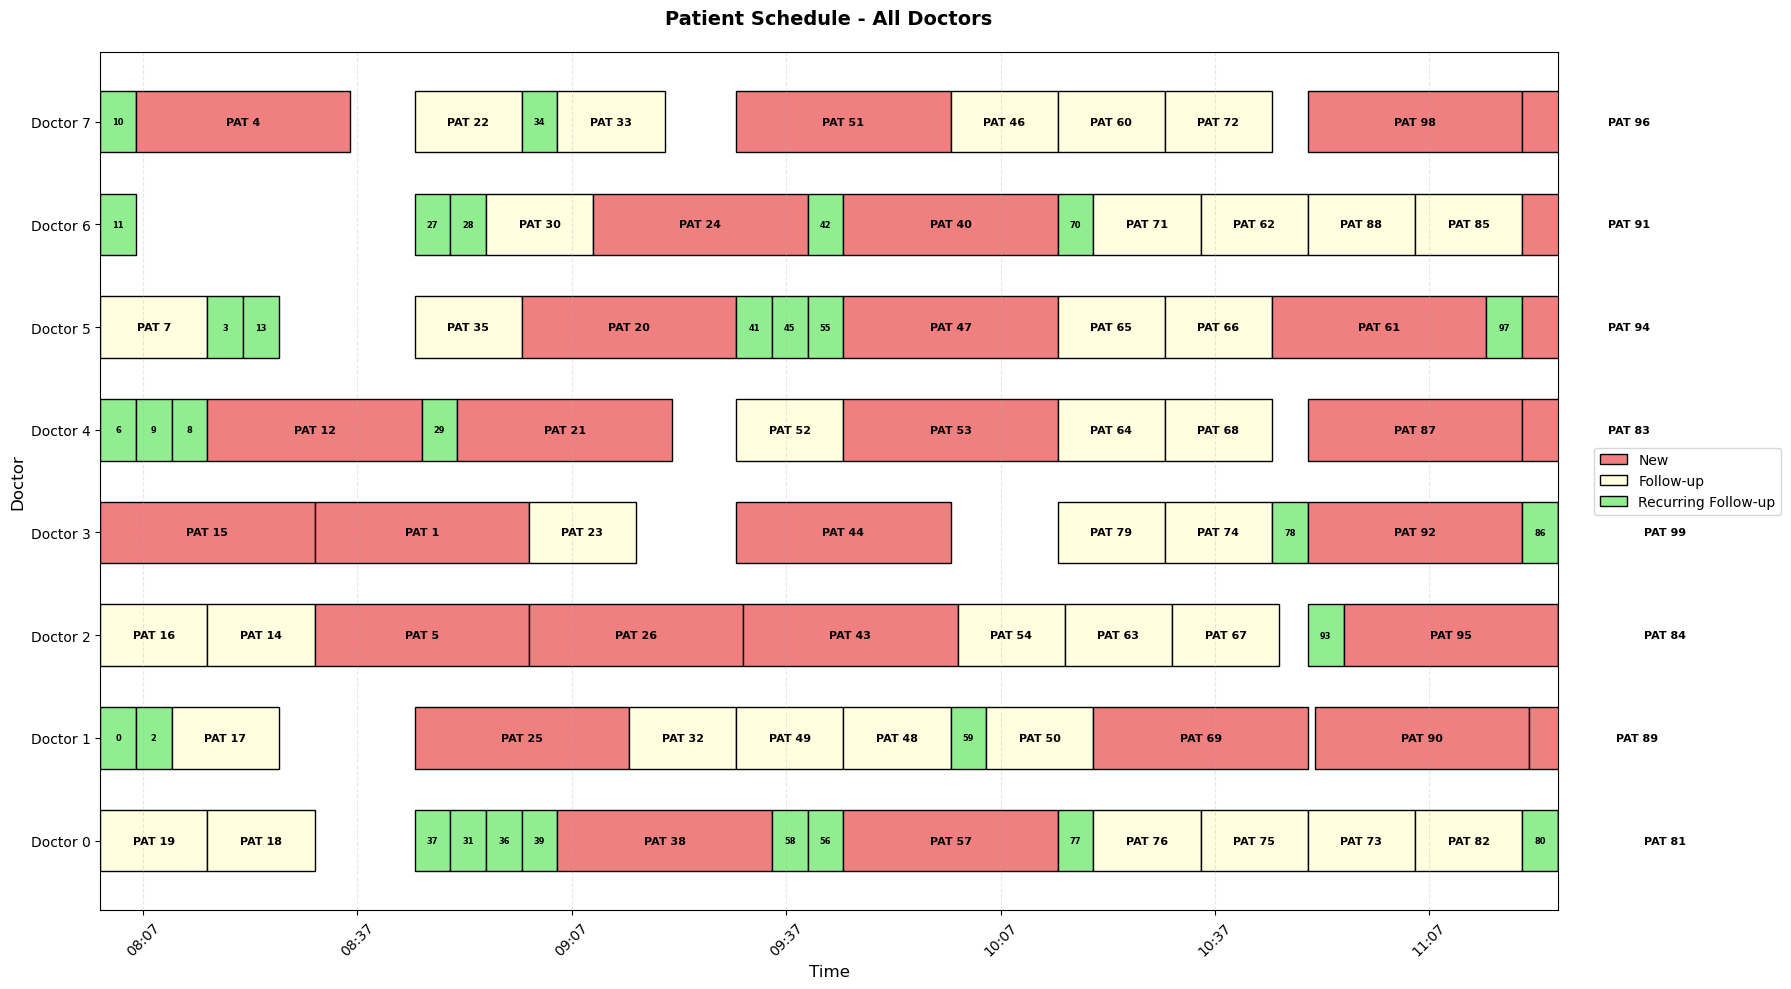

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
import matplotlib.dates as mdates
import numpy as np

# Assuming you already have your doctor_dfs dictionary from the previous code
# Let's combine all doctor dataframes back together with machine number

# Combine all doctor dataframes and add machine number back
all_doctors_df = []
for doctor_num in range(8):
    temp_df = doctor_dfs[doctor_num].copy()
    temp_df['machine'] = doctor_num
    all_doctors_df.append(temp_df)

df = pd.concat(all_doctors_df, ignore_index=True)

# Add a reference date (e.g., today) to create full datetime objects
reference_date = date.today()

def time_to_datetime(t):
    return datetime.combine(reference_date, t)

df['start_dt'] = df['start_time'].apply(time_to_datetime)
df['end_dt'] = df['end_time'].apply(time_to_datetime)

# Create the plot with larger figure size and adjust layout for legend
fig, ax = plt.subplots(figsize=(18, 10))

# Define colors based on appointment length
def get_color_by_duration(processing_time):
    if processing_time < 10:
        return 'lightgreen'  # Recurring Follow-up
    elif processing_time <= 20:
        return 'lightyellow'  # Follow-up
    else:
        return 'lightcoral'  # New

for idx, row in df.iterrows():
    machine = row['machine']
    start = row['start_dt']
    end = row['end_dt']
    patient_id = row['patient_id']
    processing_time = row['processing_time']
    
    # Draw bar with color based on duration
    ax.barh(
        y=machine,
        width=(end - start),
        left=start,
        height=0.6,
        color=get_color_by_duration(processing_time),
        edgecolor='black',
        linewidth=1
    )
    
    # Only add label if processing time is long enough (e.g., > 10 minutes)
    if processing_time >= 10:
        mid = start + (end - start) / 2
        ax.text(mid, machine, f'PAT {patient_id}', 
                ha='center', va='center', fontsize=8, fontweight='bold')
    elif processing_time >= 5:
        # For smaller windows, use smaller font and just the number
        mid = start + (end - start) / 2
        ax.text(mid, machine, f'{patient_id}', 
                ha='center', va='center', fontsize=6, fontweight='bold')

# Format x-axis - changed to 30 minute intervals
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # Show every 30 minutes
plt.xticks(rotation=45)

# Set y-axis
machine_labels = [f'Doctor {i}' for i in range(8)]
ax.set_yticks(range(8))
ax.set_yticklabels(machine_labels)

ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Doctor", fontsize=12)
ax.set_title("Patient Schedule - All Doctors", fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add legend with appointment types - positioned outside the plot area to the right
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightcoral', edgecolor='black', label='New'),
    Patch(facecolor='lightyellow', edgecolor='black', label='Follow-up'),
    Patch(facecolor='lightgreen', edgecolor='black', label='Recurring Follow-up')
]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()